In [1]:
import pandas as pd
import json
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import TargetEncoder
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from skopt import BayesSearchCV
from skopt.space import Integer, Real
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from skopt import BayesSearchCV
from skopt.space import Integer
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm

In [2]:
dataframe = pd.read_csv('smoking_drinkin.csv')
dataframe

,sex,age,height,weight,waistline,sight_left,sight_right,hear_left,hear_right,SBP,...,LDL_chole,triglyceride,hemoglobin,urine_protein,serum_creatinine,SGOT_AST,SGOT_ALT,gamma_GTP,SMK_stat_type_cd,DRK_YN
0,Male,35,170,75,90.0,1.0,1.0,1.0,1.0,120.0,...,126.0,92.0,17.1,1.0,1.0,21.0,35.0,40.0,1.0,Y
1,Male,30,180,80,89.0,0.9,1.2,1.0,1.0,130.0,...,148.0,121.0,15.8,1.0,0.9,20.0,36.0,27.0,3.0,N
2,Male,40,165,75,91.0,1.2,1.5,1.0,1.0,120.0,...,74.0,104.0,15.8,1.0,0.9,47.0,32.0,68.0,1.0,N
3,Male,50,175,80,91.0,1.5,1.2,1.0,1.0,145.0,...,104.0,106.0,17.6,1.0,1.1,29.0,34.0,18.0,1.0,N
4,Male,50,165,60,80.0,1.0,1.2,1.0,1.0,138.0,...,117.0,104.0,13.8,1.0,0.8,19.0,12.0,25.0,1.0,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
991341,Male,45,175,80,92.1,1.5,1.5,1.0,1.0,114.0,...,125.0,132.0,15.0,1.0,1.0,26.0,36.0,27.0,1.0,N
991342,Male,35,170,75,86.0,1.0,1.5,1.0,1.0,119.0,...,84.0,45.0,15.8,1.0,1.1,14.0,17.0,15.0,1.0,N
991343,Female,40,155,50,68.0,1.0,0.7,1.0,1.0,110.0,...,77.0,157.0,14.3,1.0,0.8,30.0,27.0,17.0,3.0,Y
991344,Male,25,175,60,72.0,1.5,1.0,1.0,1.0,119.0,...,73.0,53.0,14.5,1.0,0.8,21.0,14.0,17.0,1.0,N


In [3]:
tamaño_muestra = 100000
stratified_sample, _ = train_test_split(dataframe, train_size=tamaño_muestra, stratify=dataframe['DRK_YN'], random_state=42)

ruta_salida = 'dataset.csv'
stratified_sample.to_csv(ruta_salida, index=False)


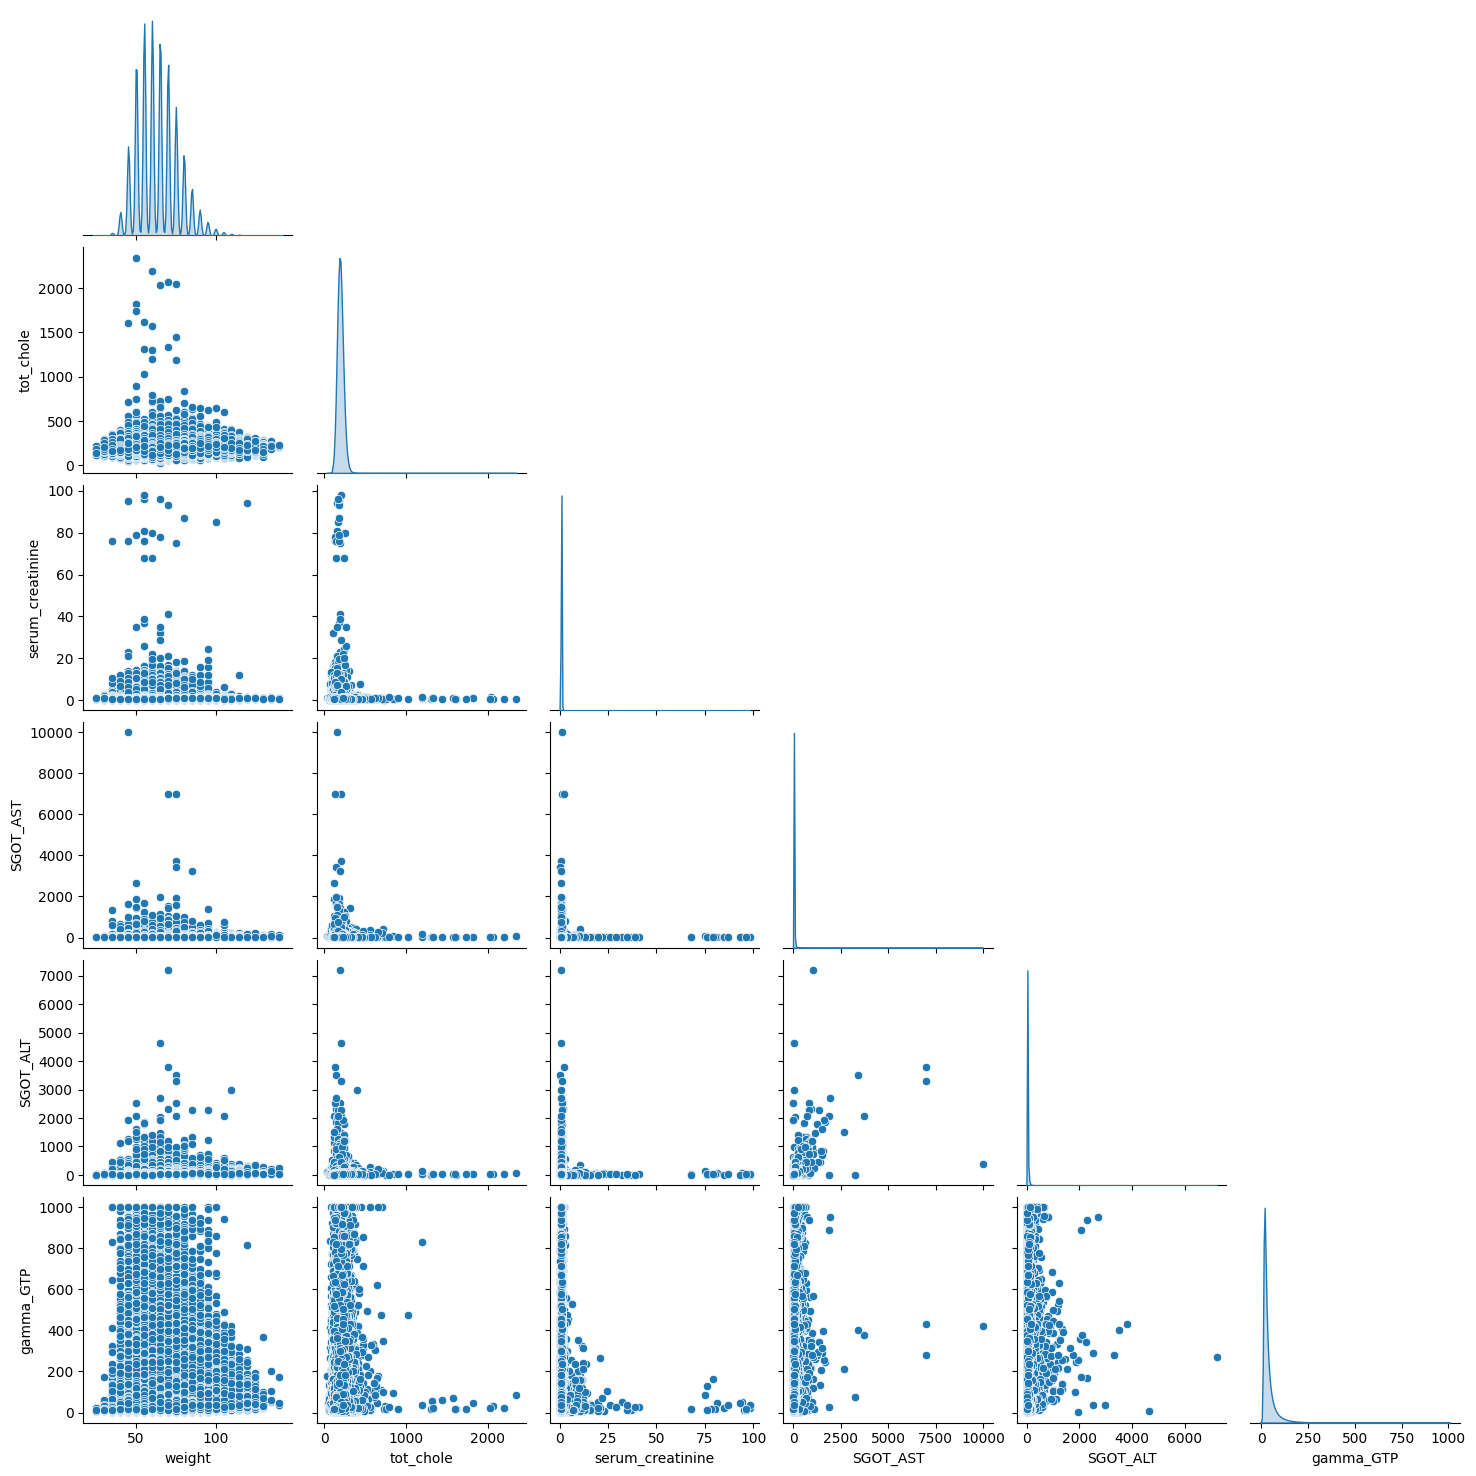

In [4]:
columns_to_plot = [ 'weight', 'tot_chole', 'serum_creatinine', 'SGOT_AST', 'SGOT_ALT', 'gamma_GTP']
sns.pairplot(dataframe[columns_to_plot], diag_kind='kde', corner=True)
plt.show()


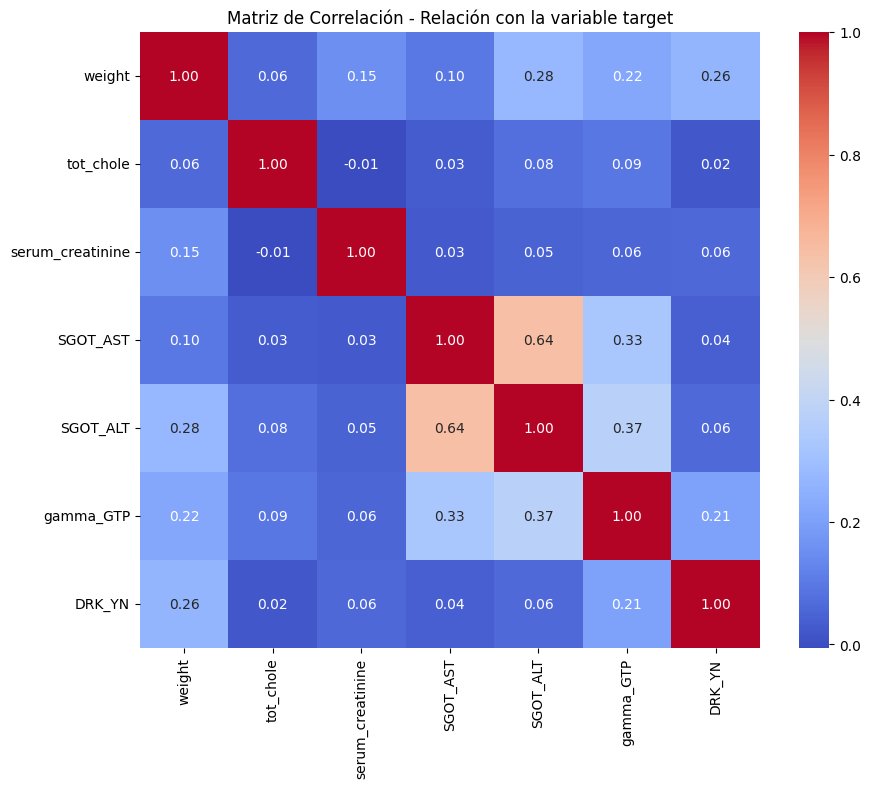

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
columns_to_plot = [ 'weight', 'tot_chole', 'serum_creatinine', 'SGOT_AST', 'SGOT_ALT', 'gamma_GTP', 'DRK_YN']
dataframe['DRK_YN'] = dataframe['DRK_YN'].map({'N': 0, 'Y': 1})
correlation_matrix = dataframe[columns_to_plot].corr()

plt.figure(figsize=(10, 8)) 
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
plt.title('Matriz de Correlación - Relación con la variable target')
plt.show()


In [6]:
df = pd.read_csv('dataset.csv')
df

,sex,age,height,weight,waistline,sight_left,sight_right,hear_left,hear_right,SBP,...,LDL_chole,triglyceride,hemoglobin,urine_protein,serum_creatinine,SGOT_AST,SGOT_ALT,gamma_GTP,SMK_stat_type_cd,DRK_YN
0,Male,55,155,70,83.0,1.0,0.9,1.0,1.0,122.0,...,88.0,80.0,14.0,1.0,0.7,25.0,31.0,91.0,2.0,Y
1,Female,40,155,50,68.0,1.2,1.0,1.0,1.0,105.0,...,109.0,111.0,12.9,1.0,0.7,15.0,11.0,13.0,1.0,N
2,Female,60,145,55,82.0,0.9,1.2,1.0,1.0,118.0,...,156.0,115.0,14.0,1.0,0.5,20.0,16.0,17.0,1.0,N
3,Male,50,180,90,92.0,0.5,0.4,1.0,1.0,130.0,...,151.0,75.0,15.8,1.0,1.0,33.0,47.0,61.0,2.0,Y
4,Female,40,155,60,84.1,1.2,1.2,1.0,1.0,108.0,...,109.0,88.0,13.2,1.0,0.6,15.0,10.0,16.0,1.0,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,Male,55,170,70,84.0,0.7,0.9,1.0,1.0,110.0,...,51.0,125.0,16.8,1.0,1.1,30.0,26.0,33.0,1.0,Y
99996,Male,35,170,75,83.0,1.2,1.2,1.0,2.0,121.0,...,124.0,184.0,16.7,1.0,1.1,27.0,37.0,33.0,2.0,Y
99997,Female,55,150,50,80.0,0.4,0.8,1.0,1.0,112.0,...,60.0,56.0,13.5,1.0,0.7,25.0,34.0,52.0,1.0,N
99998,Male,35,160,50,71.0,1.0,1.0,1.0,1.0,114.0,...,142.0,70.0,14.2,1.0,1.1,26.0,16.0,40.0,2.0,Y


In [7]:
unique_values = df['DRK_YN'].unique()
value_counts = df['DRK_YN'].value_counts()
print(f'Valores únicos: {value_counts}')   

Valores únicos: DRK_YN
N    50019
Y    49981
Name: count, dtype: int64


In [16]:
print("Cantidad de valores nulos por columna:")
print(dataframe.isnull().sum())
print("\nPorcentaje de valores nulos por columna:")
print((dataframe.isnull().sum() / len(df)) * 100)


Cantidad de valores nulos por columna:
sex                 0
age                 0
height              0
weight              0
waistline           0
sight_left          0
sight_right         0
hear_left           0
hear_right          0
SBP                 0
DBP                 0
BLDS                0
tot_chole           0
HDL_chole           0
LDL_chole           0
triglyceride        0
hemoglobin          0
urine_protein       0
serum_creatinine    0
SGOT_AST            0
SGOT_ALT            0
gamma_GTP           0
SMK_stat_type_cd    0
DRK_YN              0
dtype: int64

Porcentaje de valores nulos por columna:
sex                 0.0
age                 0.0
height              0.0
weight              0.0
waistline           0.0
sight_left          0.0
sight_right         0.0
hear_left           0.0
hear_right          0.0
SBP                 0.0
DBP                 0.0
BLDS                0.0
tot_chole           0.0
HDL_chole           0.0
LDL_chole           0.0
triglyceride      

In [8]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 991346 entries, 0 to 991345
Data columns (total 24 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   sex               991346 non-null  object 
 1   age               991346 non-null  int64  
 2   height            991346 non-null  int64  
 3   weight            991346 non-null  int64  
 4   waistline         991346 non-null  float64
 5   sight_left        991346 non-null  float64
 6   sight_right       991346 non-null  float64
 7   hear_left         991346 non-null  float64
 8   hear_right        991346 non-null  float64
 9   SBP               991346 non-null  float64
 10  DBP               991346 non-null  float64
 11  BLDS              991346 non-null  float64
 12  tot_chole         991346 non-null  float64
 13  HDL_chole         991346 non-null  float64
 14  LDL_chole         991346 non-null  float64
 15  triglyceride      991346 non-null  float64
 16  hemoglobin        99

In [8]:
# from sklearn.preprocessing import RobustScaler

# numerical_columns = df.columns[df.dtypes == 'float64'] 
# numerical_columns = numerical_columns.append(df.columns[df.dtypes == 'int64'])

# scaler = RobustScaler()
# df_scaled = df.copy()
# df_scaled[numerical_columns] = scaler.fit_transform(df[numerical_columns])

In [9]:
df['BMI'] = df['weight'] / (df['height'] / 100) ** 2
df['waist_height_ratio'] = df['waistline'] / df['height']
df['pulse_pressure'] = df['SBP'] - df['DBP']
df['hearing_diff'] = abs(df['hear_left'] - df['hear_right'])
df['log_triglyceride'] = np.log1p(df['triglyceride'])
df['log_gamma_GTP'] = np.log1p(df['gamma_GTP'])
df['protein_creatinine_ratio'] = df['urine_protein'] / df['serum_creatinine']
df['AST_ALT_ratio'] = df['SGOT_AST'] / df['SGOT_ALT']
df['avg_hearing'] = (df['hear_left'] + df['hear_right']) / 2
df['avg_sight'] = (df['sight_left'] + df['sight_right']) / 2
df['age_squared'] = df['age'] ** 2
df['BMI_cubed'] = df['BMI'] ** 3
df['age_cubed'] = df['age'] ** 3
df[['female', 'male']] = pd.get_dummies(df['sex'], drop_first=False)
df['age_gamma']= df['age']*df['gamma_GTP']
df['age_BMI'] = df['age']*df['BMI']
df['age_waist'] = df['age']*df['waistline']
df['age_pulse'] = df['age']*df['pulse_pressure']
df['age_sex']= df['age']
df['female_age'] = df['female'] * df['age']
df['male_age'] = df['male'] * df['age']
df.drop(['sex'],axis=1,inplace=True)

In [10]:
X = df.drop(['DRK_YN'], axis=1)
y = df['DRK_YN']
y = y.map({'Y': 1, 'N': 0})


In [11]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
#rf_model = RandomForestClassifier(random_state=42)
#encoder = TargetEncoder(smooth='auto')
#pipeline = Pipeline(steps=[('classifier', rf_model)])

In [13]:
pipeline = Pipeline([
    ('classifier', xgb.XGBClassifier(random_state=42))
])

In [14]:
param_space = {
    "classifier__n_estimators": Integer(600, 1000),
    "classifier__max_depth": Integer(100, 220),
    "classifier__learning_rate": (0.01, 0.1, 'uniform'),  
    "classifier__subsample": (0.5, 1.0, 'uniform'), 
    "classifier__colsample_bytree": (0.8, 1.0, 'uniform'),  
}

opt = BayesSearchCV(
    estimator=pipeline,
    search_spaces=param_space,
    n_iter=20,  
    scoring='accuracy',  
    n_jobs=-1,
    random_state=42
)


progress_bar = tqdm(total=opt.n_iter, desc="BayesSearchCV Progress", unit="iteration")

def on_step(optim_result):
    """
    Callback para actualizar la barra de progreso después de cada iteración.
    """
    progress_bar.update(1)


opt.fit(X_train, y_train, callback=on_step)
progress_bar.close()
y_pred = opt.predict(X_val)

print("Mejores hiperparámetros:", opt.best_params_)
print("Accuracy:", accuracy_score(y_val, y_pred))
print("Reporte de clasificación:")
print(classification_report(y_val, y_pred))


BayesSearchCV Progress: 100%|██████████| 1/1 [02:27<00:00, 147.72s/iteration]


Mejores hiperparámetros: OrderedDict({'classifier__colsample_bytree': 0.8820207917706628, 'classifier__learning_rate': 0.07549531688595926, 'classifier__max_depth': 212, 'classifier__n_estimators': 726, 'classifier__subsample': 0.8350739741344673})
Accuracy: 0.7298
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.73      0.72      0.73     10016
           1       0.73      0.74      0.73      9984

    accuracy                           0.73     20000
   macro avg       0.73      0.73      0.73     20000
weighted avg       0.73      0.73      0.73     20000



In [17]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_auc_score, roc_curve

lb = LabelBinarizer()
y_val_bin = lb.fit_transform(y_val)  
y_pred_bin = lb.transform(y_pred)    
auc = roc_auc_score(y_val_bin, y_pred_bin)
print("ROC-AUC:", auc)
y_pred_proba = opt.predict_proba(X_val)[:, 1]  
auc = roc_auc_score(y_val_bin, y_pred_proba)
print("ROC-AUC:", auc)

ROC-AUC: 0.7298087483103957
ROC-AUC: 0.8116606978513865



Importancia de las variables:
                     Feature  Importance
42                female_age    0.302926
34                 age_cubed    0.131600
32               age_squared    0.068514
21          SMK_stat_type_cd    0.062294
0                        age    0.040762
36                      male    0.037182
35                    female    0.022069
20                 gamma_GTP    0.016886
25              hearing_diff    0.014820
6                  hear_left    0.014362
7                 hear_right    0.012333
30               avg_hearing    0.012290
27             log_gamma_GTP    0.011456
16             urine_protein    0.011296
12                 HDL_chole    0.011250
33                 BMI_cubed    0.010404
29             AST_ALT_ratio    0.009824
2                     weight    0.009401
17          serum_creatinine    0.009134
1                     height    0.009024
19                  SGOT_ALT    0.008885
4                 sight_left    0.008771
39                 age_wai

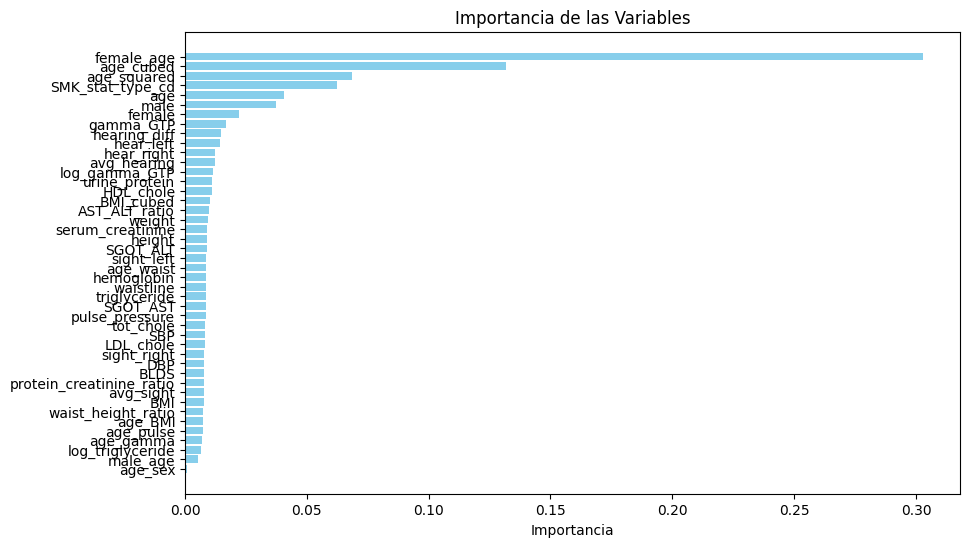

In [15]:
best_model = opt.best_estimator_.named_steps['classifier']  # Accede al clasificador del pipeline
importances = best_model.feature_importances_
feature_names = X_train.columns  
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\nImportancia de las variables:")
print(importance_df)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel("Importancia")
plt.title("Importancia de las Variables")
plt.gca().invert_yaxis()
plt.show()


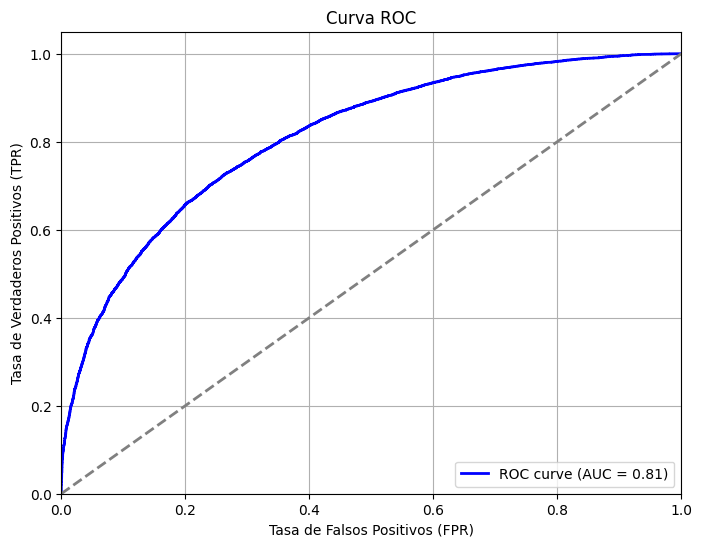

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)  
roc_auc = auc(fpr, tpr)  

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2) 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.grid()
plt.show()
